In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets

%matplotlib inline

In [2]:
input_file = "resources/speeds/full_train_speed_up/1.csv"

df = pd.read_csv(input_file)
df = df.drop(0)

print(df.shape)
df.head(5)

(231758, 4)


,frame,x,y,status
1,1,0.000000,-0.013672,1.0
2,1,0.008423,-0.000549,1.0
3,1,-0.024658,0.002014,1.0
4,1,0.014648,0.037109,1.0
5,1,-0.014343,0.008667,1.0


# Display data

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


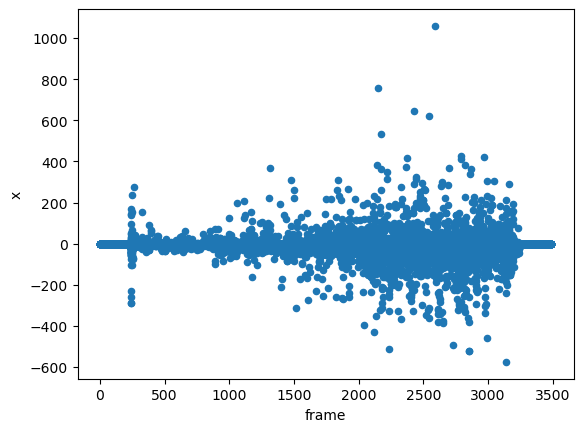

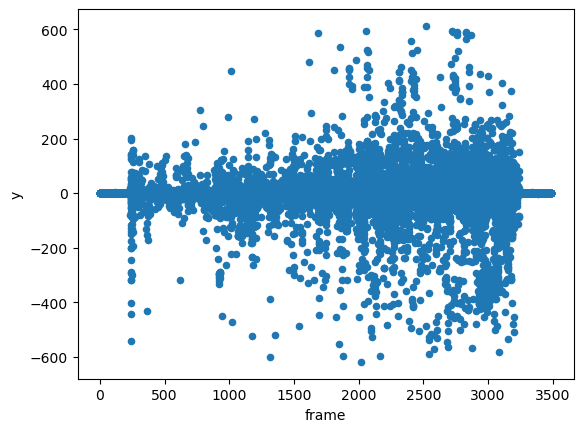

In [3]:
df_velocity = df[df.status > 0]

print(df_velocity.plot.scatter(x="frame", y="x"))
print(df_velocity.plot.scatter(x="frame", y="y"))

## Odrzucanie błędów grubych z wykorzystaniem odchylenia standardowego

In [4]:
def filter_error(df):
    headers = ["frame", "x", "y"]
    df_velocity = df[headers]

    df_velocity_mean = df_velocity.groupby(
        "frame").transform("mean").add_prefix("mean_")
    df_velocity_std = df_velocity.groupby(
        "frame").transform("std").add_prefix("std_")

    df_velocity = df_velocity.join(df_velocity_mean)
    df_velocity = df_velocity.join(df_velocity_std)

    df_velocity = df_velocity.assign(
        diff_from_mean_x=lambda x: np.abs(x.x - x.mean_x))
    df_velocity = df_velocity.assign(
        diff_from_mean_y=lambda x: np.abs(x.y - x.mean_y))

    global_std_x = df_velocity_std["std_x"].std()
    global_std_y = df_velocity_std["std_y"].std()

    magnitude = {
        "global": 4,
        "local": 3
    }

    global_condition = (df_velocity.diff_from_mean_x < global_std_x * magnitude["global"]) & (
        df_velocity.diff_from_mean_y < global_std_y * magnitude["global"])
    local_condition = (df_velocity.diff_from_mean_x < df_velocity.std_x * magnitude["local"]) & (
        df_velocity.diff_from_mean_y < df_velocity.std_y * magnitude["local"])
    filtered_velocity = df_velocity[local_condition &
                                    global_condition][headers]
    return filtered_velocity

iterations: 50
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


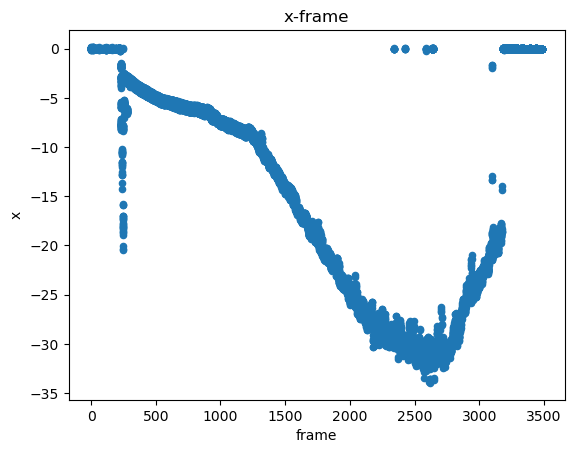

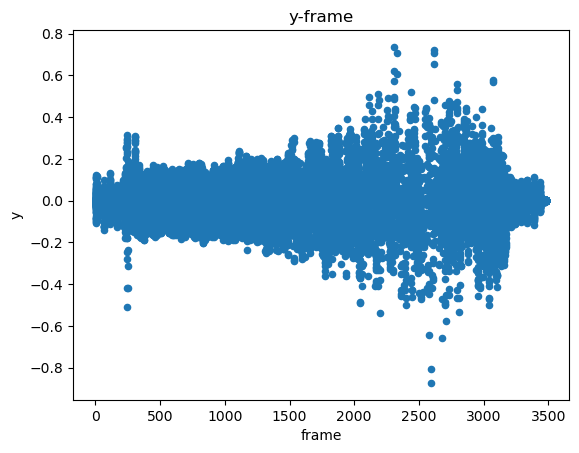

In [5]:
df_velocity = df[df.status > 0]


i = 0
while True:
    before_rows, _ = df_velocity.shape
    df_velocity = filter_error(df_velocity)
    current_rows, _ = df_velocity.shape

    i = i + 1
    if before_rows <= current_rows:
        break

print(f"iterations: {i}")
print(df_velocity.plot.scatter(x="frame", y="x", title=f"x-frame"))
print(df_velocity.plot.scatter(x="frame", y="y", title=f"y-frame"))


# Metoda regresji least-squares - na przedziałach

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


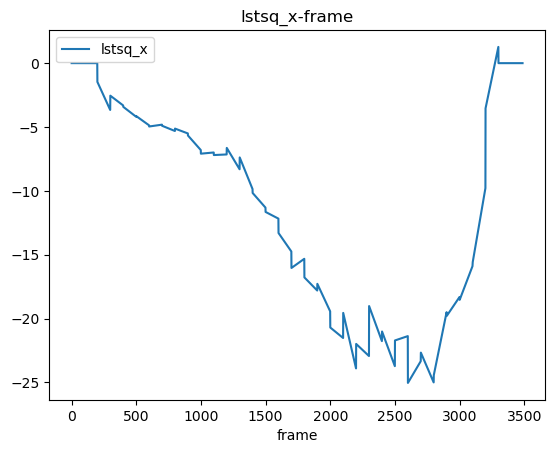

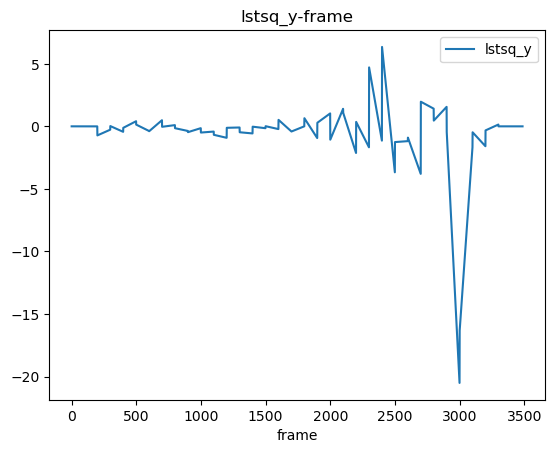

In [6]:
from scipy.linalg import lstsq
pd.set_option("mode.chained_assignment", None)

df_velocity = df[df.status > 0]

df_velocity["lstsq_x"] = 0
df_velocity["lstsq_y"] = 0

window_size = 100
max_frame = df_velocity["frame"].max() + window_size

# #  y = a + b*x
def fit_fun(p, x):
    return p[0] + p[1]*x

last_window_index = 0
for current_window_index in range(0, max_frame, window_size):
    condition = (df_velocity["frame"] >= last_window_index) & (
        df_velocity["frame"] <= current_window_index)
    df_part = df_velocity.loc[condition]

    M = df_part['frame'].to_numpy()
    x = df_part['x']
    y = df_part['y']

    M = M[:, np.newaxis] ** [0, 1]
    p_x = lstsq(M, x)[0]
    p_y = lstsq(M, y)[0]

    df_part["lstsq_x"] = fit_fun(p_x, df_part['frame'])
    df_part["lstsq_y"] = fit_fun(p_y, df_part['frame'])
    df_velocity.update(df_part)

    last_window_index = current_window_index
df_velocity

print(df_velocity.plot(x="frame", y="lstsq_x", title=f"lstsq_x-frame"))
print(df_velocity.plot(x="frame", y="lstsq_y", title=f"lstsq_y-frame"))

# Metoda regresji least-squares - z przesuwaniem okna

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


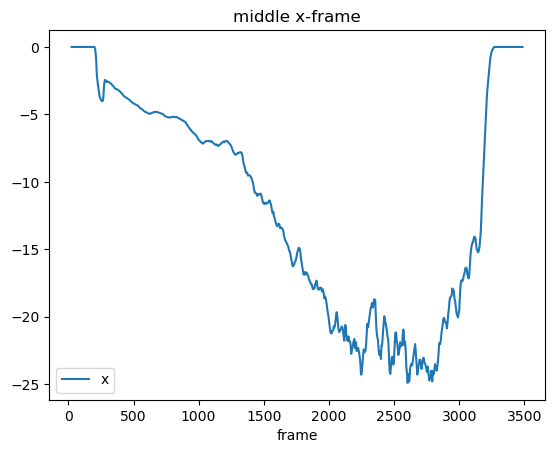

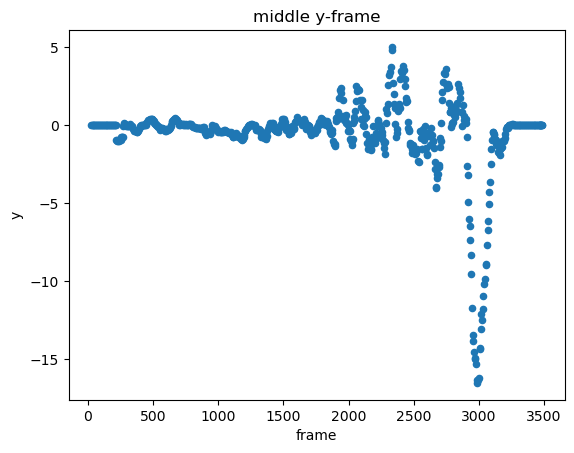

In [7]:
df_velocity = df[df.status > 0]

# #  y = a + b*x
def fit_fun(p, x):
    return p[0] + p[1]*x

middle = []

window_size = 50
window_step = 5
max_frame = df_velocity["frame"].max() + window_size
last_window_index = 0

left_iterator = range(0, max_frame, window_step)
right_iterator = range(window_size, max_frame, window_step)

for left_frame, right_frame in zip(left_iterator, right_iterator):
    condition = (df_velocity["frame"] >= left_frame) & (
        df_velocity["frame"] <= right_frame)
    df_part = df_velocity.loc[condition].reset_index()

    if not df_part.empty:
        M = df_part['frame'].to_numpy()
        x = df_part['x']
        y = df_part['y']

        M = M[:, np.newaxis] ** [0, 1]
        p_x = lstsq(M, x)[0]
        p_y = lstsq(M, y)[0]

        middle_index = len(df_part) // 2
        last_index = len(df_part) - 1

        middle_frame = df_part.iloc[middle_index]["frame"]
        last_frame = df_part.iloc[last_index]["frame"]

        middle.append((middle_frame, fit_fun(
            p_x, middle_frame), fit_fun(p_y, middle_frame)))

df_middle = pd.DataFrame(middle, columns=["frame", "x", "y"])

print(df_middle.plot(x="frame", y="x", title=f"middle x-frame"))
print(df_middle.plot.scatter(x="frame", y="y", title=f"middle y-frame"))

# Metoda regresji Ordinary Least Squares 

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


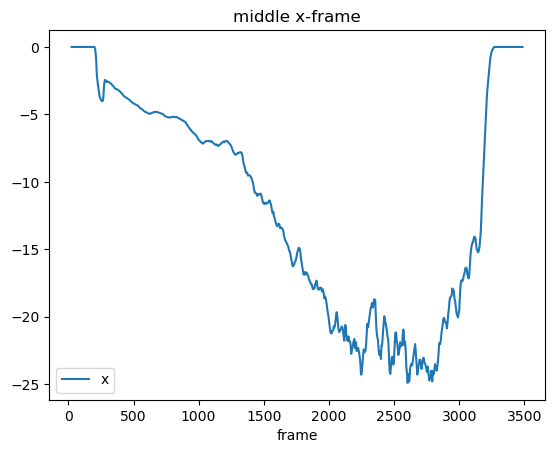

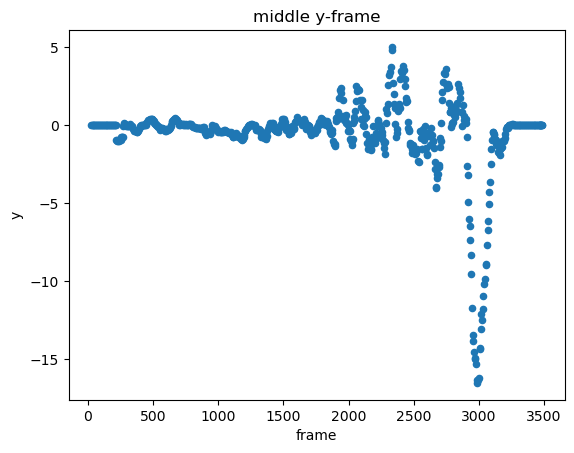

In [8]:
import statsmodels.api as sm

df_velocity = df[df.status > 0]

# #  y = a + b*x
def fit_fun(params, x):
    return params[0] + params[1]*x

# def objective_fun(params, x, y):
#     residuals = y - fit_fun(params, x)
#     weights = 

middle = []

window_size = 50
window_step = 5
max_frame = df_velocity["frame"].max() + window_size
last_window_index = 0

left_iterator = range(0, max_frame, window_step)
right_iterator = range(window_size, max_frame, window_step)

for left_frame, right_frame in zip(left_iterator, right_iterator):
    condition = (df_velocity["frame"] >= left_frame) & (
    df_velocity["frame"] <= right_frame)
    df_part = df_velocity.loc[condition].reset_index()

    if not df_part.empty:
        M = df_part['frame'].to_numpy()
        x = df_part['x']
        y = df_part['y']

        # [1, x]
        M = sm.add_constant(M)
        x_model = sm.OLS(x, M)
        y_model = sm.OLS(y, M)
        
        x_res_model = x_model.fit()
        y_res_model = y_model.fit()

        middle_index = len(df_part) // 2
        middle_frame = df_part.iloc[middle_index]["frame"]

        x_res_value = x_res_model.fittedvalues[middle_index]
        y_res_value = y_res_model.fittedvalues[middle_index]

        middle.append((middle_frame, x_res_value, y_res_value))

df_middle = pd.DataFrame(middle, columns=["frame", "x", "y"])
# df_middle
print(df_middle.plot(x="frame", y="x", title=f"middle x-frame"))
print(df_middle.plot.scatter(x="frame", y="y", title=f"middle y-frame"))

# Metoda regresji Weighted Least Squares

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


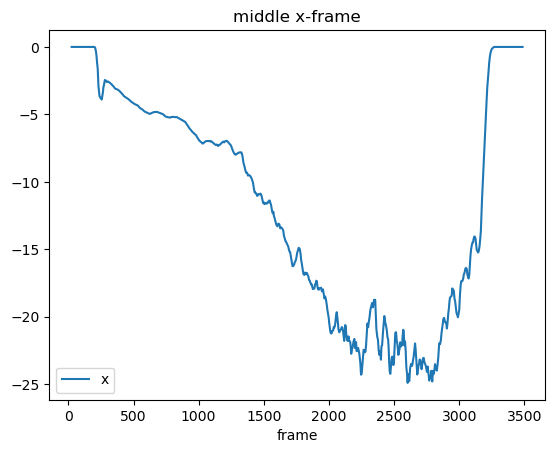

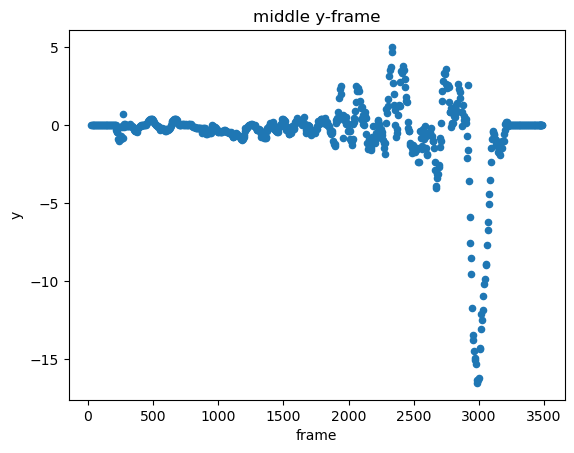

In [9]:
import statsmodels.api as sm

df_velocity = df[df.status > 0]

# #  y = a + b*x
def fit_fun(params, x):
    return params[0] + params[1]*x

def calc_weights(res_sm):
    y_resid = [abs(resid) for resid in res_sm.resid]
    X_resid = sm.add_constant(res_sm.fittedvalues)

    mod_resid = sm.OLS(y_resid, X_resid)
    res_resid = mod_resid.fit()

    mod_fv = res_resid.fittedvalues
    return  1 / (mod_fv**2)

middle = []

window_size = 50
window_step = 5
max_frame = df_velocity["frame"].max() + window_size
last_window_index = 0

left_iterator = range(0, max_frame, window_step)
right_iterator = range(window_size, max_frame, window_step)

for left_frame, right_frame in zip(left_iterator, right_iterator):
    condition = (df_velocity["frame"] >= left_frame) & (
    df_velocity["frame"] <= right_frame)
    df_part = df_velocity.loc[condition].reset_index()

    if not df_part.empty:
        M = df_part['frame'].to_numpy()
        x = df_part['x']
        y = df_part['y']

        # [1, x]
        M = sm.add_constant(M)
        x_res_model = sm.OLS(x, M).fit()
        y_res_model = sm.OLS(y, M).fit()
        
        x_res_model = sm.WLS(x, M, calc_weights(x_res_model)).fit()
        y_res_model = sm.WLS(y, M, calc_weights(y_res_model)).fit()

        middle_index = len(df_part) // 2
        middle_frame = df_part.iloc[middle_index]["frame"]

        x_res_value = x_res_model.fittedvalues[middle_index]
        y_res_value = y_res_model.fittedvalues[middle_index]

        middle.append((middle_frame, x_res_value, y_res_value))

df_middle = pd.DataFrame(middle, columns=["frame", "x", "y"])
# df_middle
print(df_middle.plot(x="frame", y="x", title=f"middle x-frame"))
print(df_middle.plot.scatter(x="frame", y="y", title=f"middle y-frame"))

# Funkcje GUI

In [10]:
from IPython.display import clear_output
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots


def iterate_over_df_with_window(df, df_frame_range, window_size, window_step, callback):
    first_frame, last_frame = df_frame_range
    last_frame += window_size 

    left_iterator = range(first_frame, last_frame, window_step)
    right_iterator = range(window_size + first_frame, last_frame, window_step)

    for left_frame, right_frame in zip(left_iterator, right_iterator):
        condition = (df["frame"] >= left_frame) & \
                    (df["frame"] <= right_frame)
        df_part = df_velocity.loc[condition].reset_index()
        
        if not df_part.empty:
            callback(df_part)

def df_frame_int_range_slider(df, step=10):
    min_frame = df_velocity["frame"].min()
    max_frame = df_velocity["frame"].max()
    int_range_slider_kwargs = {
        "value": [min_frame, max_frame],
        "min": min_frame,
        "max": max_frame,
        "step": step,
        "description": "Frame range: "
    }

    return widgets.IntRangeSlider(**int_range_slider_kwargs)

def int_progress_wrapper(int_progress):
    def inner(func):
        def wrapper (*args, **kwargs):
            func(*args, **kwargs)
            int_progress.value += 1
        return wrapper
    return inner
    

# Metoda regresji Iteratively reweighted least squares 

In [11]:
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv

df_velocity = df[df.status > 0]

# #  y = a + b*x
def fit_fun(params, x):
    return params[0] + params[1]*x

def IRLS(y, X, maxiter, w_init = 1, d = 0.0001, tolerance = 0.001):
	n,p = X.shape
	delta = array( repeat(d, n) ).reshape(1,n)
	w = repeat(1, n)
	W = diag( w )
	B = dot( inv( X.T.dot(W).dot(X) ), 
			 ( X.T.dot(W).dot(y) ) )
	for _ in range(maxiter):
		_B = B
		_w = abs(y - X.dot(B)).T
		w = float(1)/maximum( delta, _w )
		W = diag( w[0] )
		B = dot( inv( X.T.dot(W).dot(X) ), 
				 ( X.T.dot(W).dot(y) ) )
		tol = sum( abs( B - _B ) ) 
		if tol < tolerance:
			return B
	return B

int_range_slider = df_frame_int_range_slider(df_velocity)
button = widgets.Button(description = "run")
int_progress = widgets.IntProgress()
out = widgets.Output()

middle = []

@int_progress_wrapper(int_progress)
def IRLS_run_on_df(df_part):
	M = df_part['frame'].to_numpy()
	x = df_part['x']
	y = df_part['y']

	# [1, x]
	M = sm.add_constant(M)
	B_x = IRLS(x, M, 2)
	B_y = IRLS(y, M, 2)

	middle_index = len(df_part) // 2
	middle_frame = df_part.iloc[middle_index]["frame"]

	middle.append((middle_frame, fit_fun(
		B_x, middle_frame), fit_fun(B_y, middle_frame)))
	

def button_on_click(button):
	kwargs = {
		"df": df_velocity,
		"df_frame_range": int_range_slider.value,
		"window_size": 50,
		"window_step": 20,
		"callback": IRLS_run_on_df
	}
	iterate_over_df_with_window(**kwargs)
	
	df_middle = pd.DataFrame(middle, columns=["frame", "x", "y"])

	with out:
		clear_output()
		print(df_middle.plot(x="frame", y="x", title=f"middle x-frame"))
		print(df_middle.plot.scatter(x="frame", y="y", title=f"middle y-frame"))
		show_inline_matplotlib_plots()
	

button.on_click(button_on_click)
display(int_range_slider, button, int_progress, out)



IntRangeSlider(value=(1, 3486), description='Frame range: ', max=3486, min=1, step=10)

Button(description='run', style=ButtonStyle())

IntProgress(value=0)

Output()

# Porównanie metod regresji

In [12]:
from abc import ABC, abstractmethod

def iterate_over_df_with_window(df, callback, df_frame_range, window_size, window_step):
    first_frame, last_frame = df_frame_range
    last_frame += window_size 

    left_iterator = range(first_frame, last_frame, window_step)
    right_iterator = range(window_size + first_frame, last_frame, window_step)

    for left_frame, right_frame in zip(left_iterator, right_iterator):
        condition = (df["frame"] >= left_frame) & \
                    (df["frame"] <= right_frame)
        df_part = df_velocity.loc[condition].reset_index()
        
        if not df_part.empty:
            callback(df_part)

def count_iterations(min_max, window, step):
    min, max = min_max
    counter = 0

    init_value = max - min
    init_value -= window

    while init_value > 0:
        init_value -= step
        counter += 1

    return counter

class RegressionMethod:
    def __init__(self, name, run_on_df_callback):
        self.name = name
        self.run_on_df_callback = run_on_df_callback

        self.progress_bar = widgets.IntProgress()
        self.progress_bar.description = self.name

        self.output = []
        self.df = []

    def run(self):
        def wrapper(df_part):
            
            self.run_on_df_callback(df_part, self.output)
            self.progress_bar.value += 1
        return wrapper

    def reset_progress_bar(self):
        self.progress_bar.value = 0

In [94]:
from scipy.optimize import least_squares


# y = p0*x0 + p1+x1 + ...
def fit_fun(p, x):
    return np.dot(p, x)    

def lstsq_method(df_part, output):
    M = df_part['frame'].to_numpy()
    x = df_part['x']
    y = df_part['y']

    M = M[:, np.newaxis] ** [0, 1]
    p_x = lstsq(M, x)[0]
    p_y = lstsq(M, y)[0]

    middle_index = len(df_part) // 2
    middle_frame = df_part.iloc[middle_index]["frame"]
    middle_arg = [1, middle_frame]

    output.append((middle_frame, fit_fun(
        p_x, middle_arg), fit_fun(p_y, middle_arg)))
    
def OLS_method(df_part, output):
    M = df_part['frame'].to_numpy()
    x = df_part['x']
    y = df_part['y']

    # [1, x]
    M = sm.add_constant(M)
    x_model = sm.OLS(x, M)
    y_model = sm.OLS(y, M)
    
    x_res_model = x_model.fit()
    y_res_model = y_model.fit()

    middle_index = len(df_part) // 2
    middle_frame = df_part.iloc[middle_index]["frame"]

    x_res_value = x_res_model.fittedvalues[middle_index]
    y_res_value = y_res_model.fittedvalues[middle_index]

    output.append((middle_frame, x_res_value, y_res_value))

def calc_weights(res_sm):
    y_resid = [abs(resid) for resid in res_sm.resid]
    X_resid = sm.add_constant(res_sm.fittedvalues)

    mod_resid = sm.OLS(y_resid, X_resid)
    res_resid = mod_resid.fit()

    mod_fv = res_resid.fittedvalues
    return  1 / (mod_fv**2)

def WLS_method(df_part, output):
    M = df_part['frame'].to_numpy()
    x = df_part['x']
    y = df_part['y']

    # [1, x]
    M = sm.add_constant(M)
    x_res_model = sm.OLS(x, M).fit()
    y_res_model = sm.OLS(y, M).fit()
    
    x_res_model = sm.WLS(x, M, calc_weights(x_res_model)).fit()
    y_res_model = sm.WLS(y, M, calc_weights(y_res_model)).fit()

    middle_index = len(df_part) // 2
    middle_frame = df_part.iloc[middle_index]["frame"]

    x_res_value = x_res_model.fittedvalues[middle_index]
    y_res_value = y_res_model.fittedvalues[middle_index]

    output.append((middle_frame, x_res_value, y_res_value))

def IRLS(y, X, maxiter, w_init = 1, d = 0.0001, tolerance = 0.001):
	n,p = X.shape
	delta = array( repeat(d, n) ).reshape(1,n)
	w = repeat(1, n)
	W = diag( w )
	B = dot( inv( X.T.dot(W).dot(X) ), 
			 ( X.T.dot(W).dot(y) ) )
	for _ in range(maxiter):
		_B = B
		_w = abs(y - X.dot(B)).T
		w = float(1)/maximum( delta, _w )
		W = diag( w[0] )
		B = dot( inv( X.T.dot(W).dot(X) ), 
				 ( X.T.dot(W).dot(y) ) )
		tol = sum( abs( B - _B ) ) 
		if tol < tolerance:
			return B
	return B

def IRLS_method(df_part, output):
    M = df_part['frame'].to_numpy()
    x = df_part['x']
    y = df_part['y']

    # [1, x]
    M = sm.add_constant(M)
    B_x = IRLS(x, M, 2)
    B_y = IRLS(y, M, 2)

    middle_index = len(df_part) // 2
    middle_frame = df_part.iloc[middle_index]["frame"]

    output.append((middle_frame, fit_fun(
        B_x, middle_frame), fit_fun(B_y, middle_frame)))
    

def find_weights(x, y):
    def object_function(weights):
        # shape - [N, 1]
        wM_weights = weights.reshape(len(weights), 1)
        
        [1, x]
        wx = x * (np.sqrt(wM_weights)  ** [0, 1])
        wy = y * np.sqrt(weights)

        resid = lstsq(wx, wy)[1] 
        return resid

    w0 = np.random.rand(len(x))
    res = least_squares(object_function, w0, bounds=(0, 1), max_nfev=1)
    return res.x  

def WLS_least_squares(df_part, output):
    M = df_part['frame'].to_numpy()
    x = df_part['x'].to_numpy()
    y = df_part['y'].to_numpy()

    # [1, x]
    N = len(M)
    M = M.reshape(N, 1) ** [0, 1]

    # weights = np.random.rand(N)
    # M[:, 1] = M[:, 1] * np.sqrt(weights)
    # x = x * np.sqrt(weights)
    # y = y * np.sqrt(weights)

    weights = find_weights(M, x)
    M[:, 1] = M[:, 1] * np.sqrt(weights)
    x = x * np.sqrt(weights)
    y = y * np.sqrt(weights)

    # OLS
    b_x, resid_x = lstsq(M, x)[:2]
    b_y, resid_y = lstsq(M, y)[:2]
    # print(resid_x)

    middle_index = len(df_part) // 2
    middle_frame = df_part.iloc[middle_index]["frame"]
    middle_arg = [1, middle_frame]

    output.append((middle_frame, fit_fun(b_x, middle_arg), fit_fun(b_y, middle_arg)))




In [98]:
df_velocity = df[df.status > 0]

methods = [
     RegressionMethod("lstsq", lstsq_method),
     RegressionMethod("OLS", OLS_method),
     RegressionMethod("WLS", WLS_method),
    # RegressionMethod("IRLS", IRLS_method),
	# RegressionMethod("WLS_least_squares", WLS_least_squares),
	
]

int_range_slider = df_frame_int_range_slider(df_velocity)
button = widgets.Button(description = "run")
window_size_bounded_text= widgets.BoundedIntText(description="window size:", value=25, max=1000)
window_step_bounded_text= widgets.BoundedIntText(description="window step:", value=5, max=1000)
out = widgets.Output()

def button_on_click(button):

	out.clear_output()
	kwargs = {
		"df_frame_range": int_range_slider.value,
		"window_size": window_size_bounded_text.value,
		"window_step": window_step_bounded_text.value,
	}
	iterations = count_iterations(*list(kwargs.values()))
	
	for method in methods:
		method.progress_bar.max = iterations
		with out:
			display(method.progress_bar)

	for method in methods:
		iterate_over_df_with_window(df_velocity, method.run(), **kwargs)
		method.df = pd.DataFrame(method.output, columns=["frame", "x", "y"])
		method.output = []

	left_frame, right_frame = int_range_slider.value
	condition = (df_velocity["frame"] >= left_frame) & (df_velocity["frame"] <= right_frame)

	# x plots
	with out:
			print(df_velocity.loc[condition].plot.scatter(x="frame", y="x", title=f"original x-frame"))

	for method in methods:
		with out:
			print(method.df.plot(x="frame", y="x", title=f"{method.name} x-frame"))
			show_inline_matplotlib_plots()
	
	# y plots
	with out:
			print(df_velocity.loc[condition].plot.scatter(x="frame", y="y", title=f"original y-frame"))

	for method in methods:
		with out:
			print(method.df.plot(x="frame", y="y", title=f"{method.name} y-frame"))
			show_inline_matplotlib_plots()

		method.reset_progress_bar()

	

button.on_click(button_on_click)
display(int_range_slider, window_size_bounded_text, window_step_bounded_text)
display(button, out)


IntRangeSlider(value=(1, 3486), description='Frame range: ', max=3486, min=1, step=10)

BoundedIntText(value=25, description='window size:', max=1000)

BoundedIntText(value=5, description='window step:', max=1000)

Button(description='run', style=ButtonStyle())

Output()